In this notebook, we show that our algorithm is capable of retrieving hidden to hidden neuron connections looking only at the visible spiking patterns.

### Circularly connected hidden units

In [1]:
import torch as t
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from RTRBM.RTRBM_batches import RTRBM
from utils.plots import *

C:\Users\CP\OneDrive\RU\Intern\Master\utils\plots.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


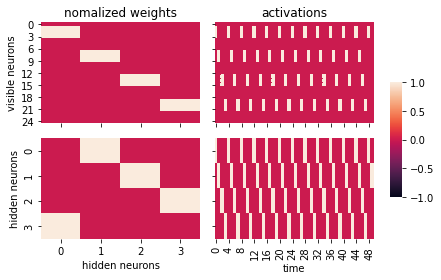

In [9]:
N_V = 25 # number of visible neurons
N_H = 4 # number of hidden neurons
T = 50 # number of timesteps

# create tensors
VH = t.zeros(N_H, N_V)
HH = t.zeros(N_H, N_H)

# assign visible - hidden and hidden - hidden connections of neurons
VH[0,1] = 1
VH[0,2] = 1
VH[0,3] = 1
VH[1,7] = 1
VH[1,8] = 1
VH[1,9] = 1
VH[2,13] = 1
VH[2,14] = 1
VH[2,15] = 1
VH[3,19] = 1
VH[3,20] = 1
VH[3,21] = 1
HH[0,1] = 1
HH[1,2] = 1
HH[2,3] = 1
HH[3,0] = 1
VT = t.zeros(N_V, T)
HT = t.zeros(N_H, T)

HT[:,0] = t.tensor([1,0,0,0]) # initial hidden states

# run simplified spiking network
for tt in range(1, T):
    VT[:,tt-1] = HT[:,tt-1] @ VH > t.rand(N_V)
    HT[:,tt] = HT[:,tt-1] @ HH > t.rand(N_H)

plot_visible_hidden_weights_activations(VH, HH, VT, HT)

Above, we created a network where a subset of visible neurons is connected to one hidden neuron. For instance, hidden neuron 0 is connected to visible neurons 1, 2 and 3. We can see that at time t=0, hidden neuron 0 is activated, thus visible neurons 1, 2 and 3 are also activated. 

The hidden - hidden weights define the states of the hidden neurons at the next timestep, t=1. Because hidden neuron 0 is connected to hidden neuron 1 this neuron is activated. The corresponding connected visible neurons (7, 8 and 9) also fire, thus creating a pattern which we can see in the figure above.

The next step is to train our RTRBM (sparsity turned off) to see if it can recover these hidden neuron connections.

100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:42<00:00, 187.65it/s]


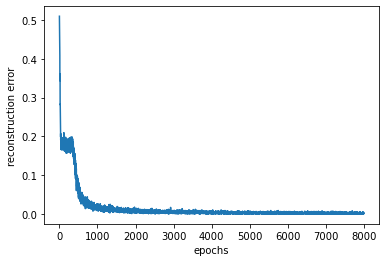

C:\Users\CP\OneDrive\RU\Intern\Master\utils\plots.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


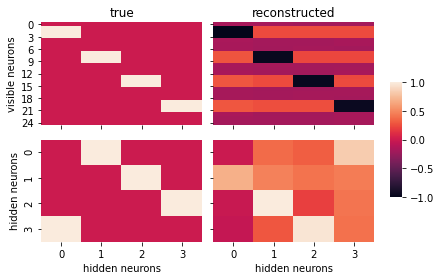

In [33]:
# build RTRBM
rtrbm = RTRBM(VT)

# train RTRBM
rtrbm.learn(N_H, 
            mean_field='False',
            spars_penalty=3e-5, x=2, sp=False,
            activationFunction=t.sigmoid,
            learning_rate=1e-3, learning_rate_decay=False,
            momentum=0.9,
            weightcost=0.0002,
            CDk=10,
            n_epochs=8000,
            batchsize=128,
            disable_tqdm=False)

# plot errors vs epochs
plt.plot(rtrbm.errors)
plt.xlabel("epochs")
plt.ylabel("reconstruction error")
plt.show()

# plot the true and reconstructed weights (VH and HH)
plot_weights_true_reconstructed(VH, HH, rtrbm.W , rtrbm.W_acc, normalize_weights=True)

After normalizing the trained weights, the pattern of hidden neuron connections reappears. Thus, the RTRBM can recover underlying hidden neuron dynamics, even though it has only seen the activity of the visible neurons. Now, let's try with batches:

In [3]:
import torch
import numpy as np


N_V = 16 # number of visible neurons
N_H = 4 # number of hidden neurons
T = 32 # number of timesteps
n_batches = 256 # number of batches

# create tensors
HH = torch.zeros(N_H, N_H)
HT = torch.zeros(N_H,T,n_batches)
VT = torch.zeros(N_V,T,n_batches)

# define hidden - hidden connections
HH[0,1] = 1
HH[1,2] = 1
HH[2,3] = 1
HH[3,0] = 1

# randomly assign 4 visibles to 4 hiddens
VH = torch.zeros(N_H, N_V)
idx = np.random.permutation(N_V)
VH[0,idx[0:3]] = 1
VH[1,idx[4:7]] = 1
VH[2,idx[8:12]] = 1
VH[3,idx[13:16]] = 1

# run simplified spiking network with multiple batches
for batch in range(n_batches):
    
    
    
    HT[:,0,batch] = torch.tensor([1,0,0,0]) # initial hidden states
    for tt in range(1, T):
        VT[:,tt-1,batch] = HT[:,tt-1,batch].T @ VH + 0.01*torch.randn(N_V) > torch.rand(N_V)
        HT[:,tt,batch] = HT[:,tt-1,batch] @ HH + 0.01*torch.randn(N_H) > torch.rand(N_H)

In [4]:
from RTRBM.RTRBM_batches_in_funcs import RTRBM
from tqdm.notebook import tqdm

# build RTRBM
rtrbm = RTRBM(VT, N_H)
n_epochs = 500
HH_recon = torch.zeros(N_H, N_H, n_epochs)
VH_recon = torch.zeros(N_H, N_V, n_epochs)

# train RTRBM
for epoch in tqdm(range(n_epochs)):
    rtrbm.learn(spars_penalty=3e-5, x=2, sp=False,
                activationFunction=torch.sigmoid,
                learning_rate=1e-4, learning_rate_decay=False,
                momentum=0.9,
                weightcost=0.0002,
                CDk=10,
                n_epochs=1,
                batchsize=16,
                disable_tqdm=True)
    HH_recon[:,:,epoch] = rtrbm.W_acc
    VH_recon[:,:,epoch] = rtrbm.W


<IPython.core.display.Javascript object>


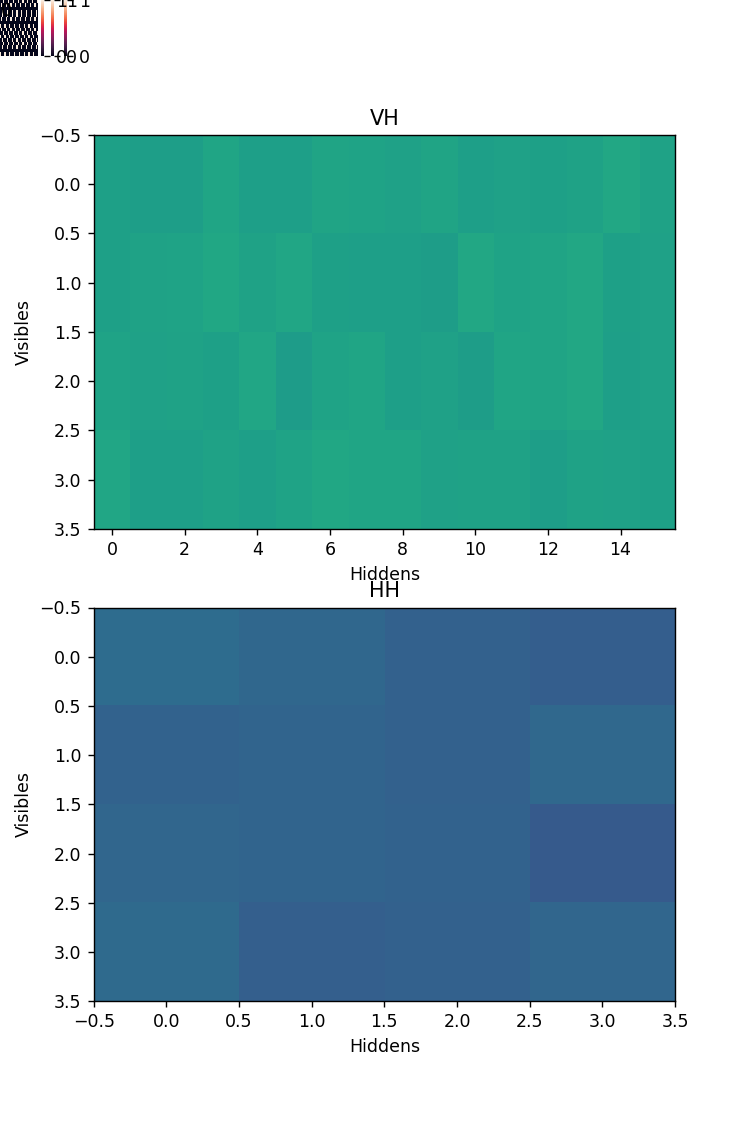

In [208]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

snapshots_VH = [VH_recon[:,:,i] for i in range(n_epochs)]
snapshots_HH = [HH_recon[:,:,i] for i in range(n_epochs)]

fig, axes = plt.subplots(2, 1, figsize=(6,9))
im_VH = axes[0].imshow(snapshots_VH[0], interpolation='None', aspect='auto', vmin=VH_recon.ravel().min(), vmax=VH_recon.ravel().max())
im_HH = axes[1].imshow(snapshots_HH[0], interpolation='None', aspect='auto', vmin=HH_recon.ravel().min(), vmax=HH_recon.ravel().max())
axtext = fig.add_axes([0.0, 0.95, 0.1, 0.05])
axtext.axis('off')

time = axtext.text(0.5, 0.5, str(0), ha="left", va="top")
time1 = axtext.text(0.5, -18, str(0), ha="left", va="bottom")

axes[0].set_xlabel('Hiddens')
axes[0].set_ylabel('Visibles')
axes[0].set_title('VH')

axes[1].set_xlabel('Hiddens')
axes[1].set_ylabel('Visibles')
axes[1].set_title('HH')

def animate_func(i):
    im_VH.set_array(snapshots_VH[i])
    im_HH.set_array(snapshots_HH[i])
    time.set_text(str(i))
    time1.set_text(str(i))
    
    return [im_VH, im_HH, time, time1]

anim = animation.FuncAnimation(fig, animate_func, frames=n_epochs, interval=1, blit=False)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 30.50it/s]


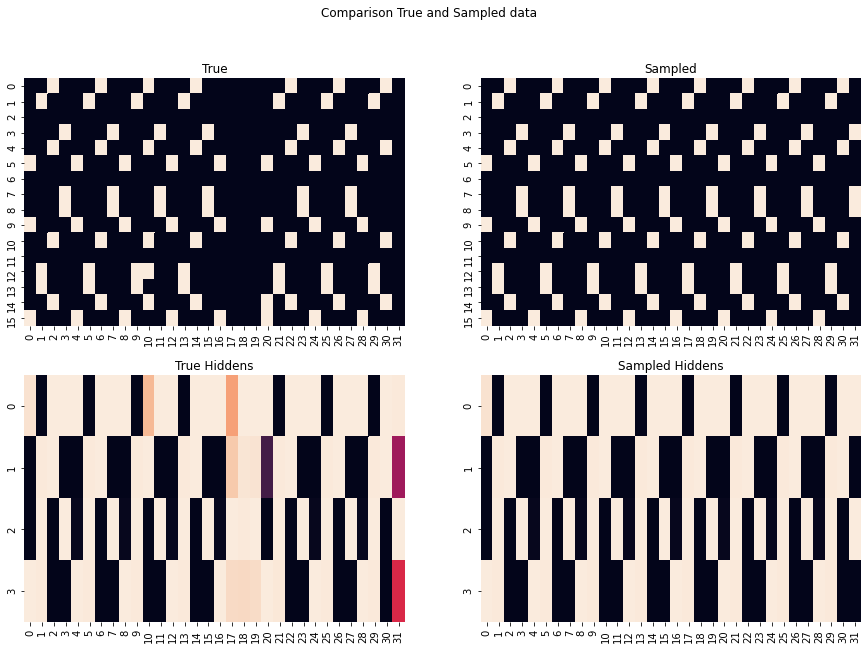

In [8]:
from utils.plots import *

sample = 1
vt_infer, rt_infer = rtrbm.infer(VT[:,0:8,sample], pre_gibbs_k=500, gibbs_k=100, mode=3)

plot_true_sampled(VT[:,:,sample], rtrbm.visible_to_hidden(VT[:,:,sample]), vt_infer, rt_infer)

<AxesSubplot:>

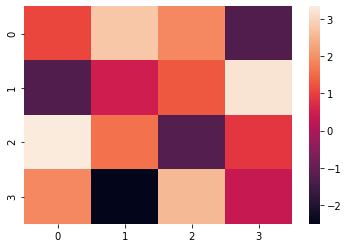

In [14]:
sns.heatmap(rtrbm.W_acc)